In [39]:
#!python --version
#!python -c "import sys; print(sys.executable)"
#!python -m pip install --upgrade pip
#!pip uninstall -y tensorflow tensorflow-intel keras tensorboard tensorboard-data-server numpy pandas scikit-learn matplotlib seaborn
#!pip cache purge
#!pip install tensorflow==2.15.1 numpy==1.26.4 pandas==2.1.4 scikit-learn==1.3.2 matplotlib==3.8.2 seaborn==0.13.2 scipy==1.11.4
#!pip install ipykernel
#!python -m ipykernel install --user --name tf310 --display-name "Python (tf310)" 

In [40]:
#import tensorflow as tf
#print(tf.__version__)

# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import random
from scipy.signal import filtfilt
import colorsys
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler 

#for deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation, Masking, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import History, EarlyStopping
from tensorflow.keras import backend as K

In [3]:
def prepare_data(fd='001'):
    index_cols = ["UnitNumber", "Cycle"]
    op_cols = [f"OpSet{i}" for i in range(1, 4)]
    sensor_cols = [f"Sensor{i}" for i in range(1, 22)]
    cols = index_cols + op_cols + sensor_cols

    train = pd.read_csv(f"CMAPSSData/train_FD{fd}.txt", sep=" ", header=None)
    train = train.dropna(axis=1)
    train.columns = cols

    test = pd.read_csv(f"CMAPSSData/test_FD{fd}.txt", sep=" ", header=None)
    test = test.dropna(axis=1)
    test.columns = cols

    rul = pd.read_csv(f"CMAPSSData/RUL_FD{fd}.txt", header=None, names=["RUL"])
    rul["UnitNumber"] = rul.index + 1

    # Compute RUL for training
    max_cycle = train.groupby("UnitNumber")["Cycle"].max().reset_index()
    max_cycle.columns = ["UnitNumber", "MaxCycle"]
    train = train.merge(max_cycle, on="UnitNumber")
    train["RUL"] = train["MaxCycle"] - train["Cycle"]
    train.drop("MaxCycle", axis=1, inplace=True)

    return train, test, rul, sensor_cols + op_cols

In [5]:
df_train_before, df_test_before, y_true, features = prepare_data()
df_train_before.shape, df_test_before.shape, y_true.shape

((20631, 27), (13096, 26), (100, 2))

In [6]:
features

['Sensor1',
 'Sensor2',
 'Sensor3',
 'Sensor4',
 'Sensor5',
 'Sensor6',
 'Sensor7',
 'Sensor8',
 'Sensor9',
 'Sensor10',
 'Sensor11',
 'Sensor12',
 'Sensor13',
 'Sensor14',
 'Sensor15',
 'Sensor16',
 'Sensor17',
 'Sensor18',
 'Sensor19',
 'Sensor20',
 'Sensor21',
 'OpSet1',
 'OpSet2',
 'OpSet3']

In [7]:
cols_to_drop = [
    'OpSet3', 'Sensor1', 'Sensor5', 'Sensor6',
    'Sensor10', 'Sensor14', 'Sensor16',
    'Sensor18', 'Sensor19'
]

In [9]:
RUL_CAP = 125
df_train_before['RUL'] = df_train_before['RUL'].clip(upper=RUL_CAP)

In [10]:
df_train = df_train_before.drop(cols_to_drop, axis=1)

In [11]:
df_test = df_test_before.drop(cols_to_drop, axis=1)

In [12]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL'])

In [13]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))
df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.transform(df_test[feats])

In [14]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

In [15]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [16]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
    Prepare test data into (samples, time steps, features)
    Returns ONLY the last sequence per unit
    """

    df_mask = pd.DataFrame(
        mask_value,
        index=range(seq_length - 1),
        columns=id_df.columns
    )

    id_df = pd.concat([df_mask, id_df], ignore_index=True)

    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]

    start = num_elements - seq_length
    stop = num_elements

    return np.array([data_array[start:stop, :]])


In [17]:
sequence_length = 50
mask_value = 0

In [18]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(15731, 50, 15)


In [19]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "RUL")) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(15731,)

In [20]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 50, 15)


In [21]:
y_test = y_true.RUL.values
y_test.shape

(100,)

In [23]:
y_test.shape

(100,)

In [24]:
nb_features = x_train.shape[2]
nb_out = 1

In [30]:
history = History()

model = Sequential()

model.add(Masking(mask_value=0.0,
                  input_shape=(sequence_length, nb_features)))

model.add(LSTM(
         units=64,   #changed from 100 to 64
         return_sequences=True,
         input_shape=(sequence_length, nb_features)))
model.add(Dropout(0.2))
model.add(LSTM(
          units=100,
          return_sequences=False))
model.add(Dropout(0.2))

#model.add(Dense(units=1, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss="mse", optimizer="rmsprop", metrics=['mse'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_1 (Masking)         (None, 50, 15)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 64)            20480     
                                                                 
 dropout_2 (Dropout)         (None, 50, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               66000     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 86581 (338.21 KB)
Trainable params: 8658

In [31]:
#%%time
# fit the model
#model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1, callbacks = [history, keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')]) '''

In [32]:
weights = np.exp(-y_train / 40)

In [33]:
%%time
model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    callbacks=[
        history,
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)


Epoch 1/100


443/443 [==============================] - 24s 40ms/step - loss: 3440.2891 - mse: 3440.2891 - val_loss: 2044.5157 - val_mse: 2044.5157
Epoch 2/100
443/443 [==============================] - 16s 36ms/step - loss: 874.5733 - mse: 874.5733 - val_loss: 592.3826 - val_mse: 592.3826
Epoch 3/100
443/443 [==============================] - 17s 37ms/step - loss: 241.9535 - mse: 241.9535 - val_loss: 183.9599 - val_mse: 183.9599
Epoch 4/100
443/443 [==============================] - 16s 37ms/step - loss: 187.2623 - mse: 187.2623 - val_loss: 224.5580 - val_mse: 224.5580
Epoch 5/100
443/443 [==============================] - 16s 36ms/step - loss: 169.2586 - mse: 169.2586 - val_loss: 212.7050 - val_mse: 212.7050
Epoch 6/100
443/443 [==============================] - 16s 36ms/step - loss: 156.1495 - mse: 156.1495 - val_loss: 216.1101 - val_mse: 216.1101
Epoch 7/100
443/443 [==============================] - 16s 36ms/step - loss: 145.7349 - mse: 145.7349 - val_loss: 229.0032 - val_mse: 22

In [ ]:
#rmse = np.sqrt(np.mean((y_pred.flatten() - y_test)**2))

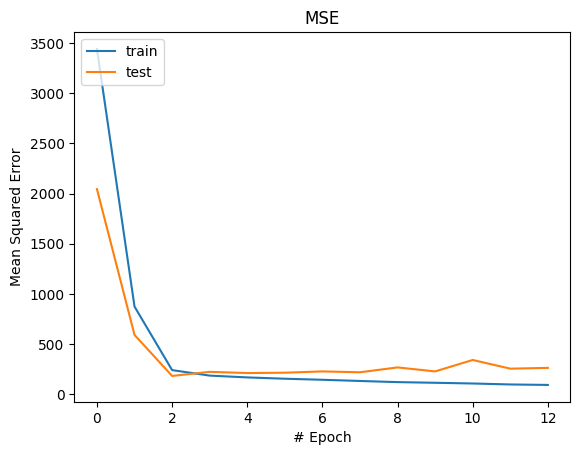

In [34]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('MSE')
plt.ylabel('Mean Squared Error')
plt.xlabel('# Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
scores = model.evaluate(x_train, y_train, verbose=1, batch_size=200)
print('MSE: {}'.format(scores[1]))

79/79 [==============================] - 3s 40ms/step - loss: 159.1454 - mse: 159.1454
MSE: 159.1454315185547


In [36]:
scores_test = model.evaluate(x_test, y_test, verbose=2)
print('MSE: {}'.format(scores_test[1]))

4/4 - 0s - loss: 217.8887 - mse: 217.8887 - 80ms/epoch - 20ms/step
MSE: 217.8887176513672


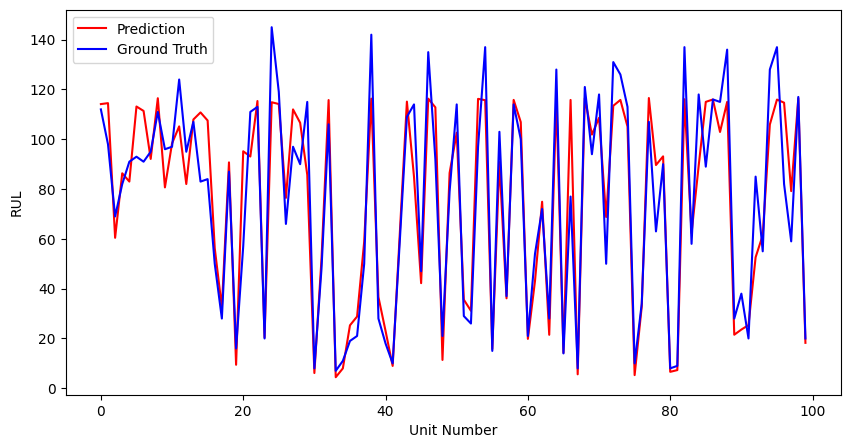

In [37]:
y_pred_test = model.predict(x_test, verbose=0)
plt.figure(figsize=(10,5))
plt.plot(y_pred_test, color='red', label='Prediction')
plt.plot(y_test, color='blue', label='Ground Truth')
plt.ylabel("RUL")
plt.xlabel("Unit Number")
plt.legend(loc='upper left')
plt.show()

In [41]:
model.save("models/rul_lstm_model")

INFO:tensorflow:Assets written to: models/rul_lstm_model\assets


INFO:tensorflow:Assets written to: models/rul_lstm_model\assets


In [42]:
def get_size(path):
    total = 0
    for root, _, files in os.walk(path):
        for f in files:
            total += os.path.getsize(os.path.join(root, f))
    print(f"Model size: {total / 1024 / 1024:.2f} MB")

get_size("models/rul_lstm_model")

Model size: 2.39 MB
